In [1]:
import sys
sys.path.append("../")

from src.common_functions import *

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

In [3]:
RAW_DATA_PATH = "../datasets/churn/e_commerce_churn.xlsx"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_excel(RAW_DATA_PATH, sheet_name="E Comm")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))

print(df.shape[0])
df.churn.value_counts()/df.shape[0]*100

5630


churn
0    83.161634
1    16.838366
Name: count, dtype: float64

In [4]:
df.isna().any()


customer_id                        False
churn                              False
tenure                              True
preferred_login_device             False
city_tier                          False
warehouse_to_home                   True
preferred_payment_mode             False
gender                             False
hour_spend_on_app                   True
number_of_device_registered        False
prefered_order_cat                 False
satisfaction_score                 False
marital_status                     False
number_of_address                  False
complain                           False
order_amount_hike_fromlast_year     True
coupon_used                         True
order_count                         True
day_since_last_order                True
cashback_amount                    False
dtype: bool

In [5]:
df.head()

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,prefered_order_cat,satisfaction_score,marital_status,number_of_address,complain,order_amount_hike_fromlast_year,coupon_used,order_count,day_since_last_order,cashback_amount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [6]:
y = "churn"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [7]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 4)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose = 1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4060 fits failed out of a total of 5040.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1680 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.8901008362026561
Best parameters: {'logistic__C': 1000, 'logistic__penalty': 'l2', 'over__sampling_strategy': 0.4, 'pca__n_components': 30, 'under__sampling_strategy': 0.3}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['preferred_login_device',
                                                   'preferred_payment_mode',
                                                   'gender',
                                                   'prefered_order_cat',
                                                   'marital_status'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.3)),
                ('over', SMOTE(sampling_strategy=0.4)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=1000))])

In [8]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [9]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
86,0.3,0.4,6,1,l2,0.779235,0.018862
338,0.3,0.4,6,10,l2,0.788140,0.009908
590,0.3,0.4,6,100,l2,0.781394,0.008698
842,0.3,0.4,6,1000,l2,0.776521,0.016711
92,0.3,0.4,10,1,l2,0.852735,0.009681
...,...,...,...,...,...,...,...
1000,0.7,1.0,26,1000,l2,0.884189,0.012017
250,0.7,1.0,30,1,l2,0.886665,0.013064
502,0.7,1.0,30,10,l2,0.885528,0.014033
754,0.7,1.0,30,100,l2,0.887691,0.011098


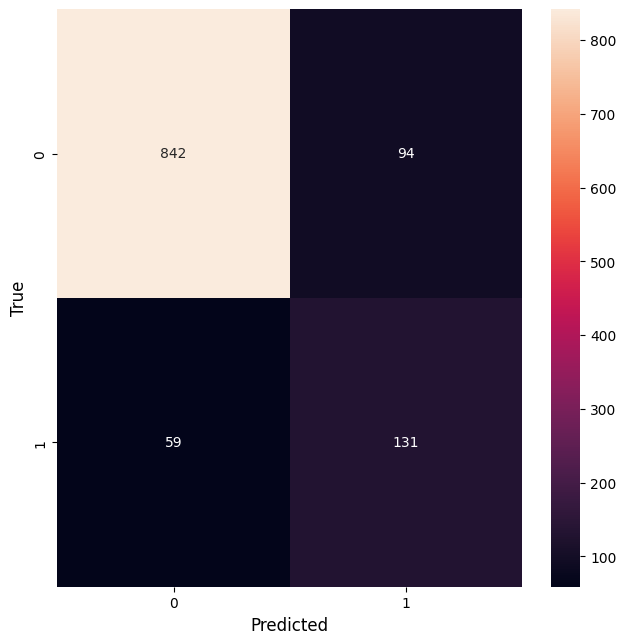

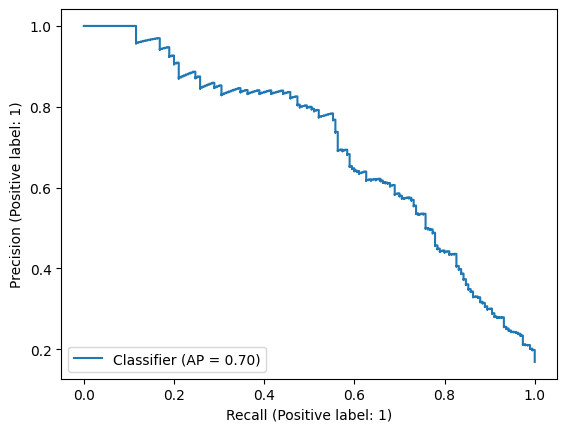

In [10]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [11]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized=True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9180995713583023
Best parameters: {'xgb__subsample': 1.0, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 2, 'xgb__colsample_bytree': 1.0, 'under__sampling_strategy': 0.3, 'pca__n_components': 35, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [12]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

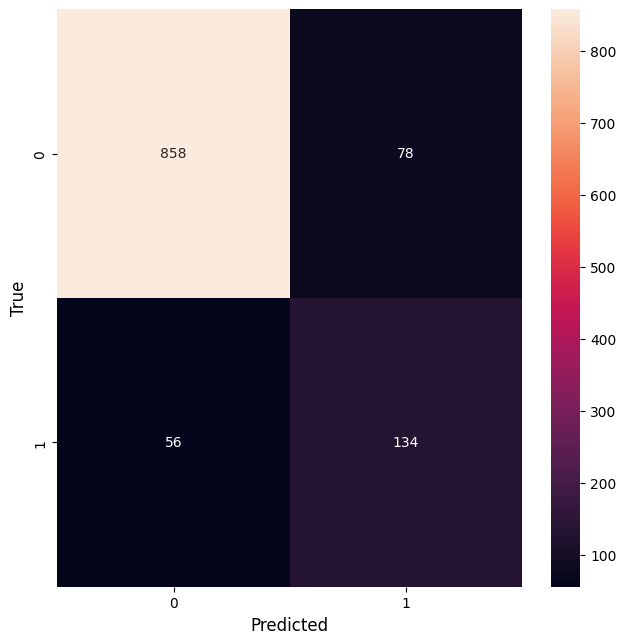

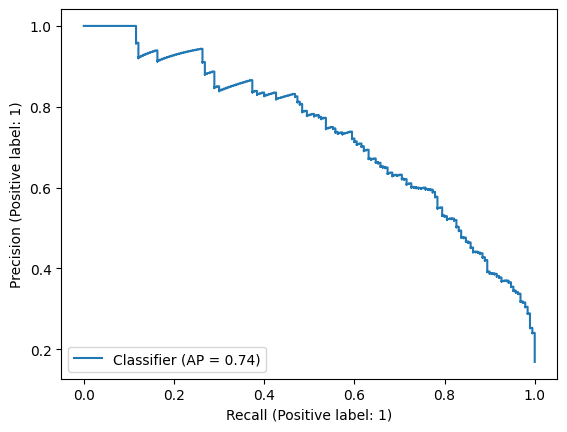

In [13]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

## Cost-based evaluation

In [14]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [15]:

test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 24496.
 total cost/loss average :  21.75488454706927


In [16]:
print(test_predictions_log[['churn', 'A', 'instance_cost', "y_predicted"]].head())

      churn      A  instance_cost  y_predicted
2959      0  110.0            0.0            0
3157      0   88.0            0.0            0
2612      0    7.0            0.0            0
1463      0    9.0            0.0            0
5449      0   48.0            0.0            0


In [17]:

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["order_count"]*test_predictions_xgb["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 23130.
 total cost/loss average :  20.541740674955594


In [18]:
print(test_predictions_xgb[['churn', "A", 'instance_cost', 'y_predicted']].iloc[56:80])

      churn      A  instance_cost  y_predicted
4295      0   20.0            0.0            0
545       0    0.0            0.0            0
1937      0   60.0            0.0            0
4533      0    2.0            0.0            0
3202      0    2.0            0.0            0
1945      0   30.0            0.0            0
1103      0   14.0            0.0            0
5395      0   40.0            0.0            0
4763      0   38.0            0.0            0
3509      0    4.0            0.0            0
2457      1    1.0           12.0            0
4041      0  110.0            0.0            0
2027      0    5.0           10.0            1
2486      0   18.0            0.0            0
2443      0   26.0            0.0            0
3043      0   77.0            0.0            0
1788      1    0.0            0.0            1
1972      0   18.0            0.0            0
4725      0    2.0            0.0            0
4641      0   16.0            0.0            0
4241      0  

# 3.1 AMC metric

Decision Threshold: 0.01, Test cost/loss = 50774.00
Decision Threshold: 0.02, Test cost/loss = 46870.00
Decision Threshold: 0.03, Test cost/loss = 41220.00


Decision Threshold: 0.04, Test cost/loss = 43240.00
Decision Threshold: 0.05, Test cost/loss = 39414.00
Decision Threshold: 0.06, Test cost/loss = 37608.00
Decision Threshold: 0.07, Test cost/loss = 37322.00
Decision Threshold: 0.08, Test cost/loss = 37398.00
Decision Threshold: 0.09, Test cost/loss = 34906.00
Decision Threshold: 0.10, Test cost/loss = 34304.00
Decision Threshold: 0.11, Test cost/loss = 34010.00
Decision Threshold: 0.12, Test cost/loss = 32962.00
Decision Threshold: 0.13, Test cost/loss = 32874.00
Decision Threshold: 0.14, Test cost/loss = 33112.00
Decision Threshold: 0.15, Test cost/loss = 32440.00
Decision Threshold: 0.16, Test cost/loss = 31624.00
Decision Threshold: 0.17, Test cost/loss = 31172.00
Decision Threshold: 0.18, Test cost/loss = 29940.00
Decision Threshold: 0.19, Test cost/loss = 29618.00
Decision Threshold: 0.20, Test cost/loss = 29424.00
Decision Threshold: 0.21, Test cost/loss = 28988.00
Decision Threshold: 0.22, Test cost/loss = 28872.00
Decision Thr

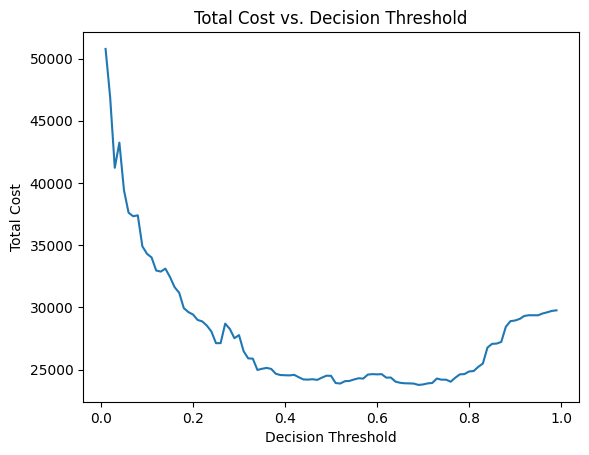

In [19]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log")

Decision Threshold: 0.01, Test cost/loss = 45880.00
Decision Threshold: 0.02, Test cost/loss = 39940.00
Decision Threshold: 0.03, Test cost/loss = 34580.00
Decision Threshold: 0.04, Test cost/loss = 31002.00
Decision Threshold: 0.05, Test cost/loss = 29804.00
Decision Threshold: 0.06, Test cost/loss = 28342.00
Decision Threshold: 0.07, Test cost/loss = 26982.00
Decision Threshold: 0.08, Test cost/loss = 25310.00
Decision Threshold: 0.09, Test cost/loss = 25406.00
Decision Threshold: 0.10, Test cost/loss = 24158.00
Decision Threshold: 0.11, Test cost/loss = 22794.00
Decision Threshold: 0.12, Test cost/loss = 23456.00
Decision Threshold: 0.13, Test cost/loss = 23804.00
Decision Threshold: 0.14, Test cost/loss = 22886.00
Decision Threshold: 0.15, Test cost/loss = 25722.00
Decision Threshold: 0.16, Test cost/loss = 25156.00
Decision Threshold: 0.17, Test cost/loss = 23946.00
Decision Threshold: 0.18, Test cost/loss = 23748.00
Decision Threshold: 0.19, Test cost/loss = 23530.00
Decision Thr

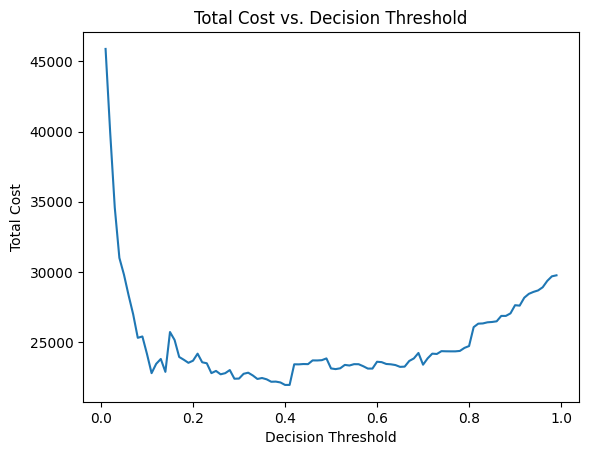

In [20]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb")

# 3.2 E-AMC evaluation metric

 # expected average profit and expected profit

In [21]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [22]:
# test_predictions_log = add_eap_ep(train, test_predictions_log, y, best_pipeline_log_reg, cb_column, model_name="log", instance_dependent_cost_type="churn")
# test_predictions_xgb = add_eap_ep(train, test_predictions_xgb, y, best_pipeline_xgb, cb_column, model_name="xgb", instance_dependent_cost_type="churn")

In [23]:
test_predictions_log

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.050401,0,1320.0,220.0,0,11.088268,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.255464,0,1056.0,176.0,0,44.961745,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.159993,0,84.0,14.0,0,2.239904,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.038222,0,108.0,18.0,0,0.687987,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.114565,0,576.0,96.0,0,10.998208,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,1,0.536098,0,24.0,4.0,0,11.133649,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,36.0,1,0.900477,0,36.0,6.0,0,3.582831,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.864216,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,24.0,0,0.414803,0,24.0,4.0,0,14.044733,19.960924


In [24]:
test_predictions_xgb

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.012234,0,1320.0,220.0,0,2.691571,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.039028,0,1056.0,176.0,0,6.868871,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.063580,0,84.0,14.0,0,0.890120,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.010956,0,108.0,18.0,0,0.197210,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.260210,0,576.0,96.0,0,24.980175,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,1,0.512741,0,24.0,4.0,0,11.694222,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,36.0,1,0.837368,0,36.0,6.0,0,5.854747,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.590780,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,24.0,0,0.436144,0,24.0,4.0,0,13.532553,19.960924


In [25]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

28077.631815998222
37086.21136767318
EAP :  24.935729854350107
EP :  32.936244553883824


In [26]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

25207.43736637279
37086.21136767318
EAP :  22.386711693048657
EP :  32.936244553883824


# mp and emp metric non instance based

In [27]:
df['cashback_amount'].mean()

177.22303019538188

In [28]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions['y_predicted_proba'], test_predictions["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1











In [29]:

test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_12800\1515637981.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.066522202486678, MP_fraction=0.238898756660746, EMP=5.113400020406429, EMP_fraction=0.23693798821056652)

In [30]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_xgb['y_predicted_proba'], test_predictions_xgb["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1






In [31]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_12800\836916586.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.456099467140319, MP_fraction=0.22291296625222023, EMP=5.5161522438551245, EMP_fraction=0.2489186678879717)

# emp metric instance based

In [32]:
cb_column = 'cb'
test[cb_column]=(test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])

test['TN'] = 0
test['FN'] = 12 *(test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])
test['FP'] = 2* (test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])
test['TP'] = 0

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)

test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

TypeError: add_eap_ep() missing 2 required positional arguments: 'cb_column' and 'churn_label'

In [ ]:
test

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,order_amount_hike_fromlast_year,coupon_used,order_count,day_since_last_order,cashback_amount,cb,TN,FN,FP,TP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,12.0,5.0,11.0,12.0,157.10,432.0,0,5184.0,864.0,0
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,14.0,7.0,8.0,NaN,213.34,NaN,0,NaN,NaN,0
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,14.0,1.0,1.0,7.0,140.01,196.0,0,2352.0,392.0,0
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,22.0,0.0,1.0,0.0,128.35,NaN,0,NaN,NaN,0
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,14.0,3.0,4.0,9.0,150.92,504.0,0,6048.0,1008.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,53766,0,6.0,Mobile Phone,1,17.0,Credit Card,Male,1.0,4,...,26.0,1.0,NaN,1.0,237.44,26.0,0,312.0,52.0,0
3016,53017,0,13.0,Computer,1,6.0,Credit Card,Male,3.0,5,...,NaN,10.0,14.0,4.0,317.72,NaN,0,NaN,NaN,0
738,50739,0,6.0,Phone,2,8.0,UPI,Male,2.0,3,...,13.0,0.0,1.0,4.0,136.00,104.0,0,1248.0,208.0,0
2969,52970,0,24.0,Mobile Phone,1,11.0,Debit Card,Male,4.0,4,...,NaN,2.0,2.0,7.0,316.44,NaN,0,NaN,NaN,0


In [ ]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

KeyError: 'EAP'

In [ ]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

172949.43342199537
348259.4014209591
EAP :  153.5962996642943
EP :  309.2889888285605


# mp instance based

In [ ]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 *a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

a = (test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])

Decision Threshold: 0.01, Test cost/loss = 294398.00
Decision Threshold: 0.02, Test cost/loss = 272914.00
Decision Threshold: 0.03, Test cost/loss = 240182.00
Decision Threshold: 0.04, Test cost/loss = 222748.00
Decision Threshold: 0.05, Test cost/loss = 211680.00
Decision Threshold: 0.06, Test cost/loss = 197714.00
Decision Threshold: 0.07, Test cost/loss = 193068.00
Decision Threshold: 0.08, Test cost/loss = 191608.00
Decision Threshold: 0.09, Test cost/loss = 182720.00
Decision Threshold: 0.10, Test cost/loss = 178652.00
Decision Threshold: 0.11, Test cost/loss = 181304.00


Decision Threshold: 0.12, Test cost/loss = 177996.00
Decision Threshold: 0.13, Test cost/loss = 183320.00
Decision Threshold: 0.14, Test cost/loss = 184604.00
Decision Threshold: 0.15, Test cost/loss = 177722.00
Decision Threshold: 0.16, Test cost/loss = 177518.00
Decision Threshold: 0.17, Test cost/loss = 173704.00
Decision Threshold: 0.18, Test cost/loss = 170614.00
Decision Threshold: 0.19, Test cost/loss = 169034.00
Decision Threshold: 0.20, Test cost/loss = 162640.00
Decision Threshold: 0.21, Test cost/loss = 161128.00
Decision Threshold: 0.22, Test cost/loss = 157524.00
Decision Threshold: 0.23, Test cost/loss = 156288.00
Decision Threshold: 0.24, Test cost/loss = 154334.00
Decision Threshold: 0.25, Test cost/loss = 151460.00
Decision Threshold: 0.26, Test cost/loss = 149290.00
Decision Threshold: 0.27, Test cost/loss = 145834.00
Decision Threshold: 0.28, Test cost/loss = 153912.00
Decision Threshold: 0.29, Test cost/loss = 152828.00
Decision Threshold: 0.30, Test cost/loss = 154

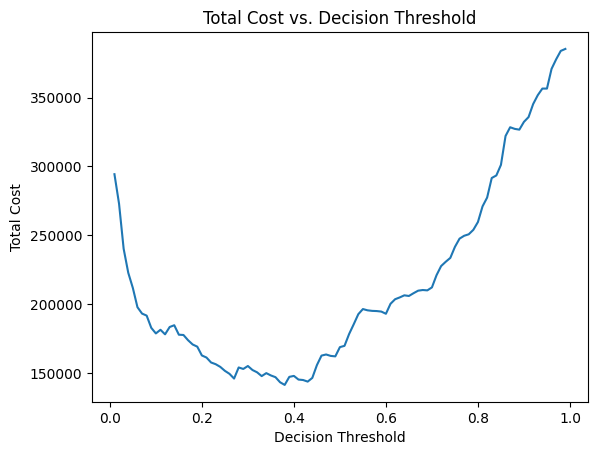

(0.38, 125.41563055062167, 141218.0)

In [ ]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = 284672.00
Decision Threshold: 0.02, Test cost/loss = 237522.00
Decision Threshold: 0.03, Test cost/loss = 214776.00
Decision Threshold: 0.04, Test cost/loss = 198134.00
Decision Threshold: 0.05, Test cost/loss = 185330.00
Decision Threshold: 0.06, Test cost/loss = 174798.00
Decision Threshold: 0.07, Test cost/loss = 163916.00
Decision Threshold: 0.08, Test cost/loss = 159160.00
Decision Threshold: 0.09, Test cost/loss = 150038.00
Decision Threshold: 0.10, Test cost/loss = 139638.00
Decision Threshold: 0.11, Test cost/loss = 134302.00
Decision Threshold: 0.12, Test cost/loss = 131222.00
Decision Threshold: 0.13, Test cost/loss = 132316.00
Decision Threshold: 0.14, Test cost/loss = 129770.00
Decision Threshold: 0.15, Test cost/loss = 126746.00
Decision Threshold: 0.16, Test cost/loss = 135780.00
Decision Threshold: 0.17, Test cost/loss = 132888.00
Decision Threshold: 0.18, Test cost/loss = 127976.00
Decision Threshold: 0.19, Test cost/loss = 131

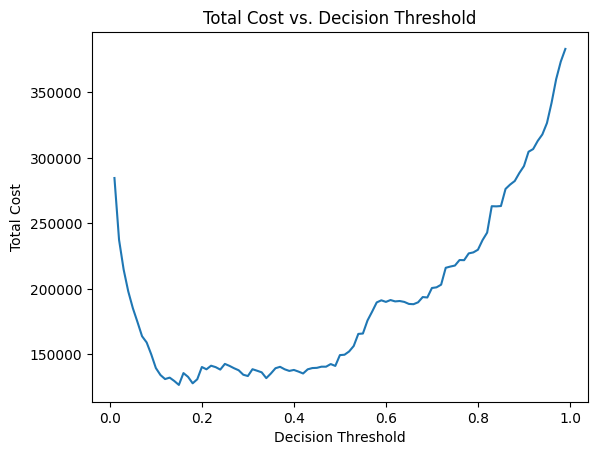

(0.15000000000000002, 112.56305506216697, 126746.0)

In [ ]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
    
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")
    

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')